In [1]:
import h2o, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmoki79zh
  JVM stdout: /tmp/tmpmoki79zh/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmoki79zh/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 14 days
H2O_cluster_name:,H2O_from_python_unknownUser_jr9aqo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


### Loading data

In [2]:
# Import the iris dataset into H2O:
iris = h2o.import_file("http://h2o-public-test-data.s3.amazonaws.com/smalldata/iris/iris_wheader.csv")
# Split the dataset into a train and valid set:
train, valid = iris.split_frame(ratios=[.7], seed=1234)
train

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


sepal_len,sepal_wid,petal_len,petal_wid,class
4.9,3,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
5,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
5.4,3.7,1.5,0.2,Iris-setosa
4.8,3.4,1.6,0.2,Iris-setosa
4.8,3,1.4,0.1,Iris-setosa


Check the class is balanced in train and validation sets?

In [3]:
from sklearn.metrics import silhouette_score

train_df = train.as_data_frame()
valid_df = valid.as_data_frame()
valid_df['class'].value_counts() / train_df['class'].value_counts()

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


class
Iris-setosa        0.612903
Iris-versicolor    0.351351
Iris-virginica     0.190476
Name: count, dtype: float64

spliting by `h2o` is not stratified by `class` so we will consider the `train-test-split` from `sklearn` instead

## 1. Traditional ML vs Kmeans

In [4]:
iris_df = iris.as_data_frame()
# Set the predictors:
predictors = ["sepal_len", "sepal_wid", "petal_len", "petal_wid"]
X = iris_df[predictors]
y = iris_df.drop(columns=predictors)
# Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=52)
y_valid['class'].value_counts() / y_train['class'].value_counts() 

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


class
Iris-setosa        0.428571
Iris-virginica     0.428571
Iris-versicolor    0.428571
Name: count, dtype: float64

Now the class in both train and validation is totally stratified for all classes. Again, we only use `X_train` and `X_valid` to verify the difference between each cluster

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_train)
kmeans.predict(X_valid)

array([0, 2, 1, 0, 0, 2, 1, 0, 2, 1, 2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 0,
       2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 2, 0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 2,
       0], dtype=int32)

#### Check the silhouette_score

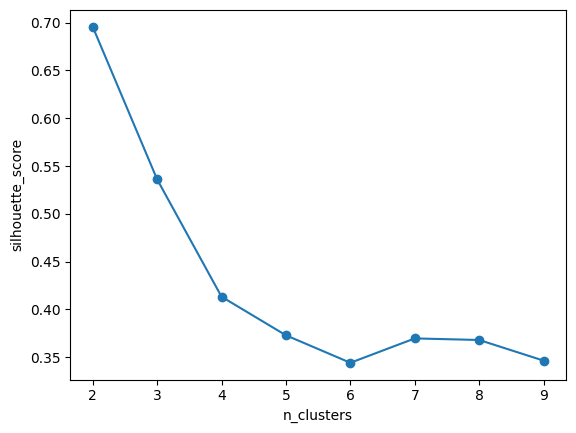

In [6]:
scores = []
for _ in range(2, 10):
    kmeans = KMeans(n_clusters=_, random_state=42, n_init="auto").fit(X_train)
    scores.append(silhouette_score(X_train, kmeans.fit_predict(X_train)))
plt.plot(list(range(2, 10)), scores, '-o')
plt.xlabel("n_clusters")
plt.ylabel("silhouette_score")
plt.show()

Hence we will stopped at $k=3$ or $k=4$

label
centroid_3    41
centroid_1    35
centroid_2    29
Name: count, dtype: int64

label
centroid_3    41
centroid_2    29
centroid_1    19
centroid_4    16
Name: count, dtype: int64

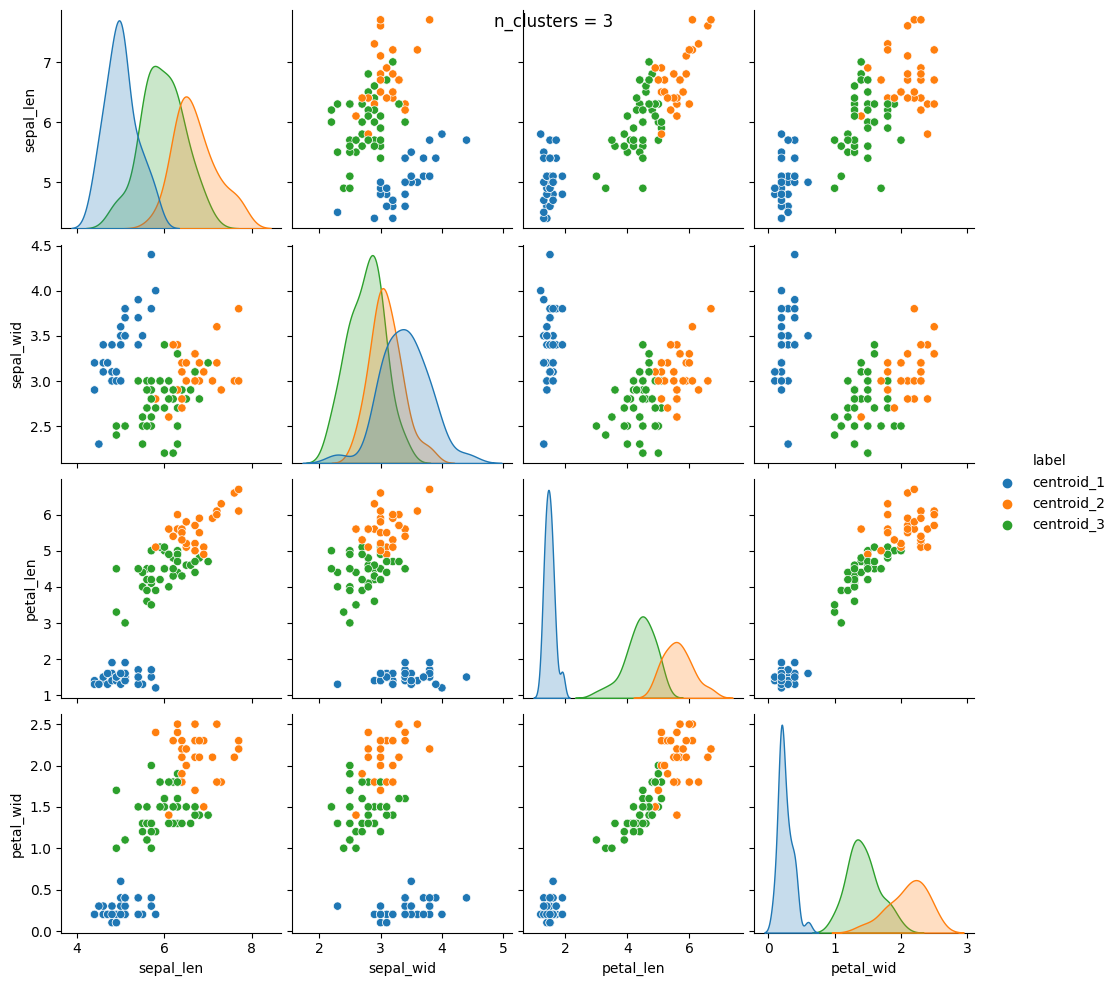

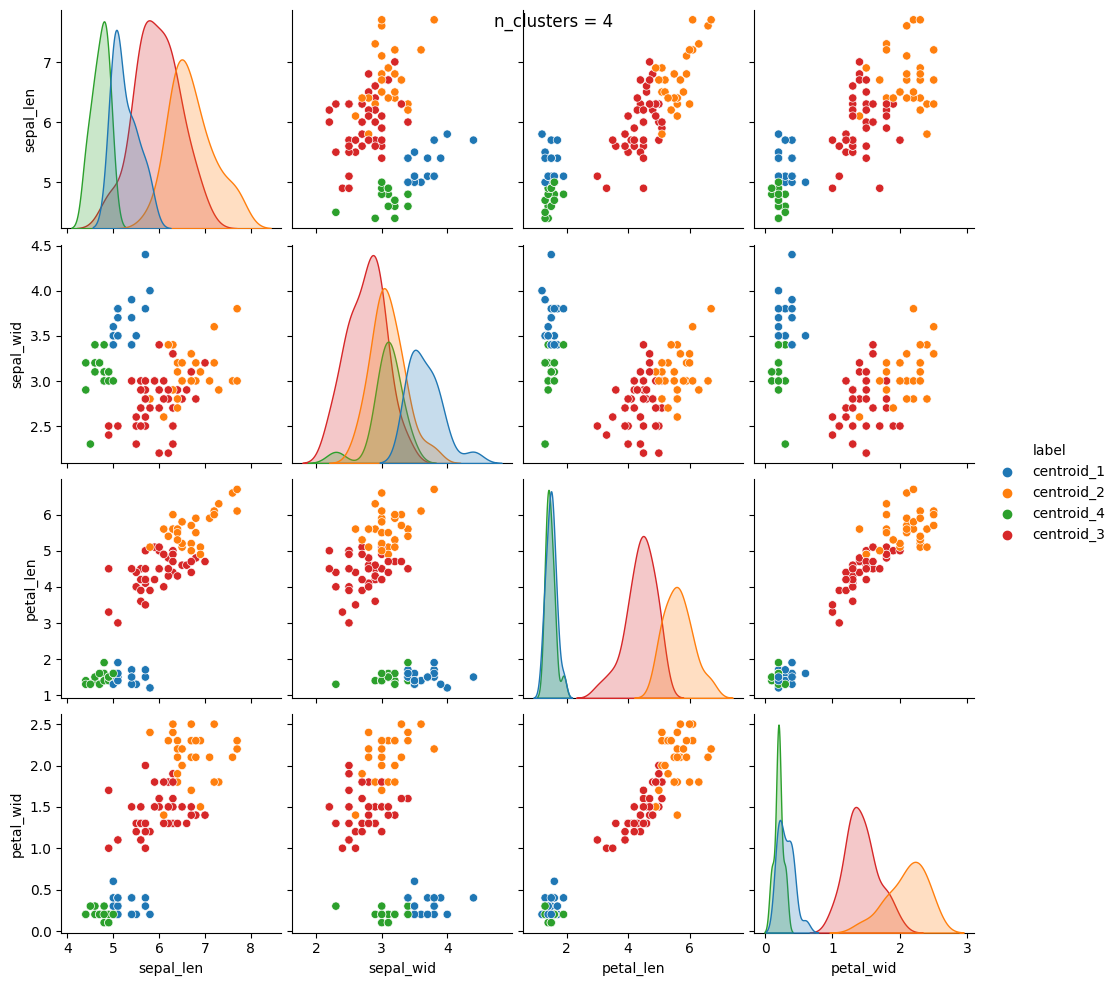

In [7]:
for idx, _ in enumerate([3, 4]):
    kmeans = KMeans(n_clusters=_, random_state=42, n_init="auto").fit(X_train)
    pred_df = X_train.copy()
    pred_df['label'] = [f"centroid_{cen+1}" for cen in kmeans.predict(X_train)]
    f = sns.pairplot(pred_df, hue="label")
    display(pred_df['label'].value_counts())
    f.fig.suptitle(f"n_clusters = {_}")

So, $k=3$ will be the best choice for this data

## 2. AutoML vs Kmeans
Initialize KMeans in h2o and recover the `X_train, X_valid` into `h2o-frame`

In [8]:
from h2o.estimators import H2OKMeansEstimator
train = h2o.H2OFrame(X_train)
valid = h2o.H2OFrame(X_valid)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


#### Build and train the model only using cross-validation on valid-data

In [9]:
iris_kmeans = H2OKMeansEstimator(k=2, # maximum k-clusters
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)
iris_kmeans.train(x=predictors,
                  training_frame=train,
                  validation_frame=valid)

# Eval performance:
perf = iris_kmeans.model_performance()
perf

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%


,centroid,size,within_cluster_sum_of_squares
,1.0,37.0,18.9913514
,2.0,68.0,75.2201457


For $k=2$ then we obtained 2 centroids

- Now, we will increase the values of $k = 10$ 

In [10]:
iris_kmeans = H2OKMeansEstimator(k=10, # maximum k-clusters
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)
iris_kmeans.train(x=predictors,
                  training_frame=train,
                  validation_frame=valid)

# Eval performance:
perf = iris_kmeans.model_performance()
perf

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%


,centroid,size,within_cluster_sum_of_squares
,1.0,35.0,10.7817146
,2.0,41.0,24.4478056
,3.0,29.0,16.5627568


The algorithms has been stoped at $k=3$ (clusters)

#### Get predictions

In [11]:
new_response = pd.DataFrame({'sepal_len': [5.1, 6.2],
                             'sepal_wid': [2.7, 3.4],
                             'petal_len': [1.9, 3.3],
                             'petal_wid': [1.2, 2.1]
                            })
new_response = h2o.H2OFrame(new_response)
#  Generate predictions on a validation set (if necessary):
pred = iris_kmeans.predict(new_response)
pred

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


predict
0
1


#### Training whole data (using KFold) 
Noting that in `h2o` the `KFold - cross validation` is not the same as `Stratified-KFold` 

In [12]:
kf_iris_kmeans = H2OKMeansEstimator(k=10, nfolds=10,
                                 max_runtime_secs=30,
                                 estimate_k=True,
                                 standardize=False,
                                 keep_cross_validation_predictions=True,
                                 keep_cross_validation_fold_assignment=True,
                                 seed=1234)
kf_iris_kmeans.train(x=predictors,
                  training_frame=iris)
kf_perf = iris_kmeans.model_performance()
kf_perf

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%


,centroid,size,within_cluster_sum_of_squares
,1.0,35.0,10.7817146
,2.0,41.0,24.4478056
,3.0,29.0,16.5627568


In [13]:
pred = kf_iris_kmeans.predict(new_response)
pred

kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


predict
0
1
